In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize' ]= 16,9

from thompson_sampling.models import BatchBayesLinReg
from thompson_sampling.solvers import GaussianContextualSampler, GaussianUniversalContextualSampler,GaussianContextualSamplerSingleModel, GaussianBandit
from thompson_sampling.models import NeuralNetwork, DenseLayer, DropoutLayer, AttentionDropoutLayer


Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
np.random.seed(4)

num_units = 4

In [ ]:
model = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)

model.addLayer( units=num_units, activation='tanh')




model.addLayer( units=1, activation='tanh',layer_type = AttentionDropoutLayer)

model.addLayer( units=num_units, activation='tanh')




model.addLayer( units=1, activation='',layer_type = AttentionDropoutLayer)
model



[
  1 -> Dense layer (nx=1, nh=10, activation=tanh)
  2 -> Dense layer (nx=10, nh=4, activation=tanh)
  3 -> Attention Dropout layer (nx=4, nh=1, activation=tanh)
  4 -> Dense layer (nx=1, nh=4, activation=tanh)
  5 -> Attention Dropout layer (nx=4, nh=1, activation=none)
]

In [ ]:
X = np.atleast_2d(np.linspace(-1,1,100))
attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention = np.random.binomial([np.ones((model.layers[2].weights.shape))],1-dropout_percent)[0]#.shape
attention

full_attention = np.ones(model.layers[2].weights.shape)


In [ ]:
yhat = []

for x in X.T:
    yhat += [model.forward(np.atleast_2d(x), attention)]

yhat = np.array(yhat)

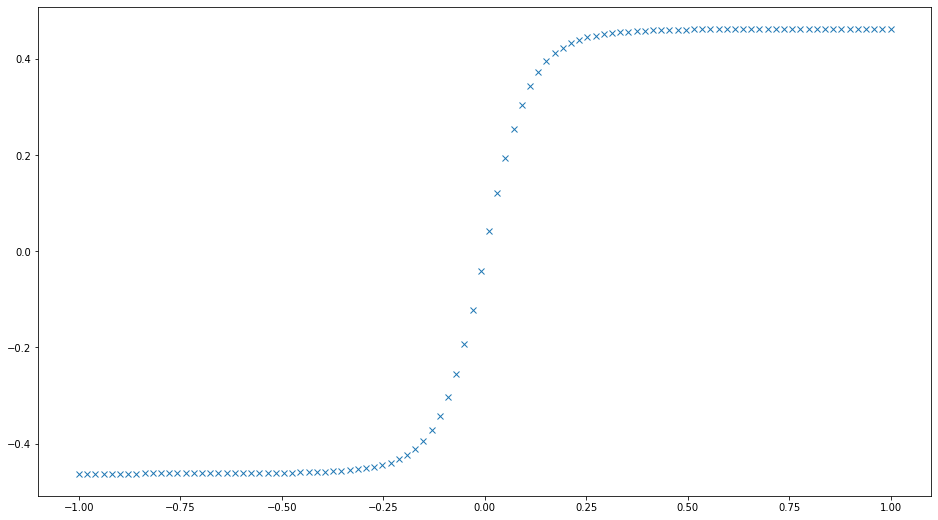

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x')

In [ ]:
yhat_full = []

for x in X.T:
    yhat_full += [model.forward(np.atleast_2d(x), full_attention)]

yhat_full = np.array(yhat_full)

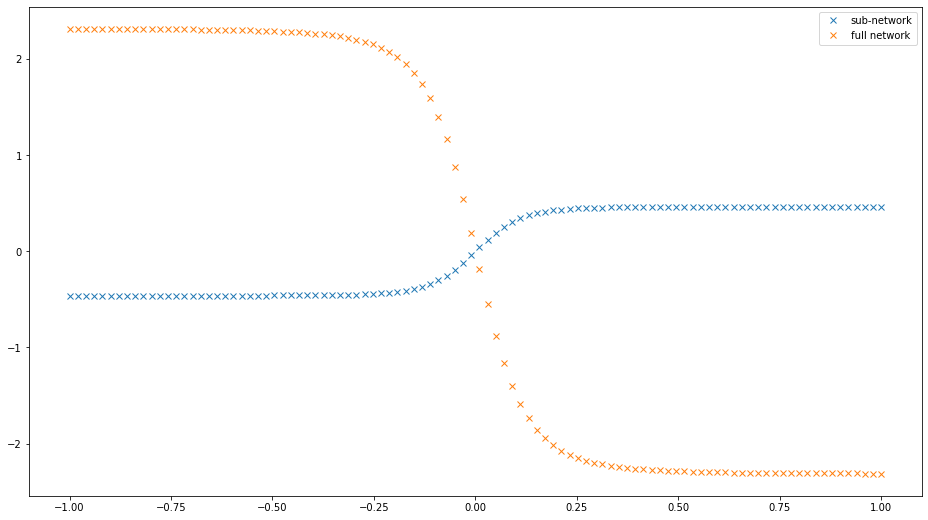

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x',label='sub-network')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x',label='full network')
plt.legend()

In [ ]:
gb = GaussianBandit(9)
[gb.choose_arm() for i in range(10)]

[3, 3, 1, 1, 8, 5, 1, 5, 6, 2]

In [ ]:
class IndependentAttentionTS():
    def __init__(self,attention_size):
        self.ts_list = [GaussianBandit(num_options=2) for arm in range(attention_size)]
        
    def get_attention(self):
        
        attention = [ts.choose_arm() for ts in self.ts_list]
        return np.atleast_2d(attention)
    
    def update(self, attention, reward):
        for i, arm in enumerate(attention):
            ts = self.ts_list[i]
            
            ts.update(arm, reward)
            
            
class DependentAttentionTS():
    def __init__(self, attention_size, num_arms):
        self.arms = list(set([tuple(np.random.choice([0,1],p=[0.5,0.5],size = attention_size)) for i in range(num_arms)]))
        self.arms = np.array([np.array(arm) for arm in self.arms])
        self.ts = GaussianBandit(len(self.arms))
        
        
    def get_arm(self):
        return self.ts.choose_arm()
        
        
    def get_attention(self, arm):
        return self.arms[arm]
    
    def update(self, arm, reward):
        self.ts.update(arm,reward)
        
        

In [ ]:
dts = DependentAttentionTS(num_units, 30)
dts.arms, len(dts.arms), dts.ts.num_options

(array([[1, 1, 0, 1],
        [1, 0, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 1, 0],
        [0, 0, 0, 1],
        [0, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [1, 0, 0, 1],
        [0, 1, 1, 0],
        [0, 0, 0, 0],
        [0, 1, 0, 1],
        [0, 0, 1, 1]]),
 14,
 14)

In [ ]:
[dts.get_arm() for i in range(10)]

[8, 1, 7, 7, 8, 6, 1, 13, 3, 1]

In [ ]:
attention in dts.arms

True

In [ ]:
epochs = 1
from sklearn.utils import shuffle

errors = []

for i in range(epochs):
    
    X_shuffle, y_shuffle = shuffle(X.T,yhat)
    for x, y in zip(X_shuffle, y_shuffle):


        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        prediction = model.forward(x, attention_new)


        error = - np.sqrt( (y - prediction)**2)
        errors.append(error)

        dts.update(arm, error[0][0])


In [ ]:
y

array([[-0.46006952]])

In [ ]:
a = [dts.get_attention(dts.get_arm()) for i in range(100)]
np.mean(a,0) > 0.5, np.mean(a,0), attention

(array([False,  True, False,  True]),
 array([0.  , 0.99, 0.  , 0.99]),
 array([[0, 1, 0, 1]]))

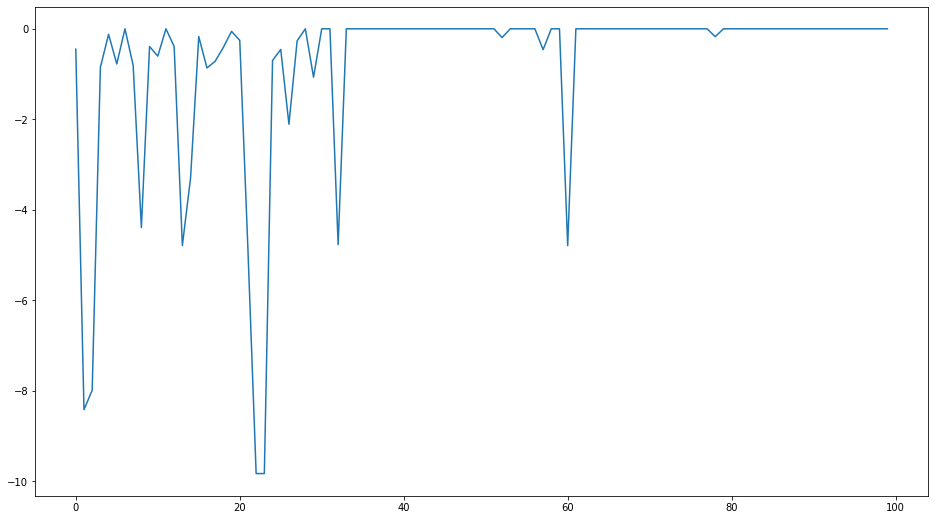

In [ ]:
plt.plot(np.array(errors).squeeze())

In [ ]:
pred_samples = 10

ensemble_preds = []
for i in range(pred_samples):
    
    predictions = []

    for x, y in zip(X.T, yhat):
    

        x = np.atleast_2d(x)
        arm = dts.get_arm()
        attention_new = dts.get_attention(arm)


        predictions += [model.forward(x, attention_new).squeeze()]


        #error = (y - prediction)**2

        #iats.update(attention.squeeze(), error.squeeze())
        #gcssm.update(arms['arm_ix'], x.squeeze(), error.squeeze())
        
    ensemble_preds.append(np.array(predictions))


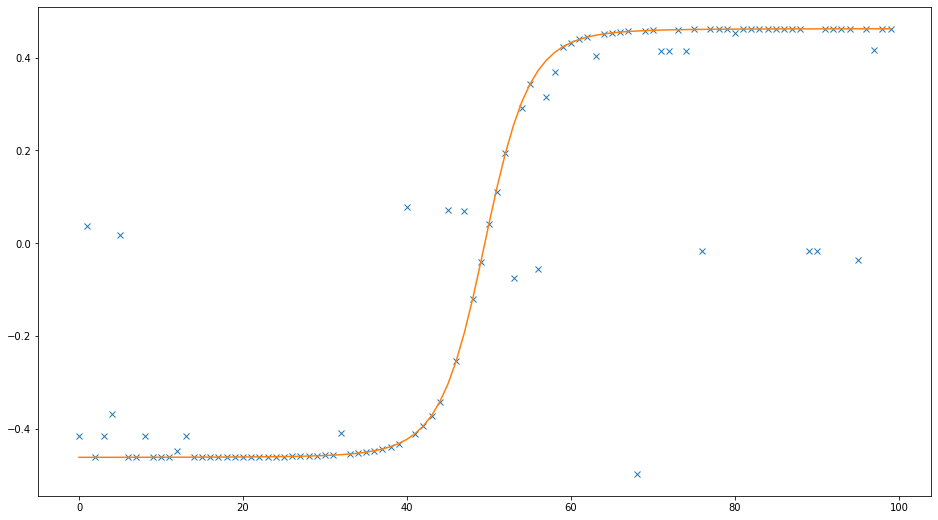

In [ ]:
plt.plot(np.mean(ensemble_preds,0),'x')

plt.plot(yhat.squeeze())

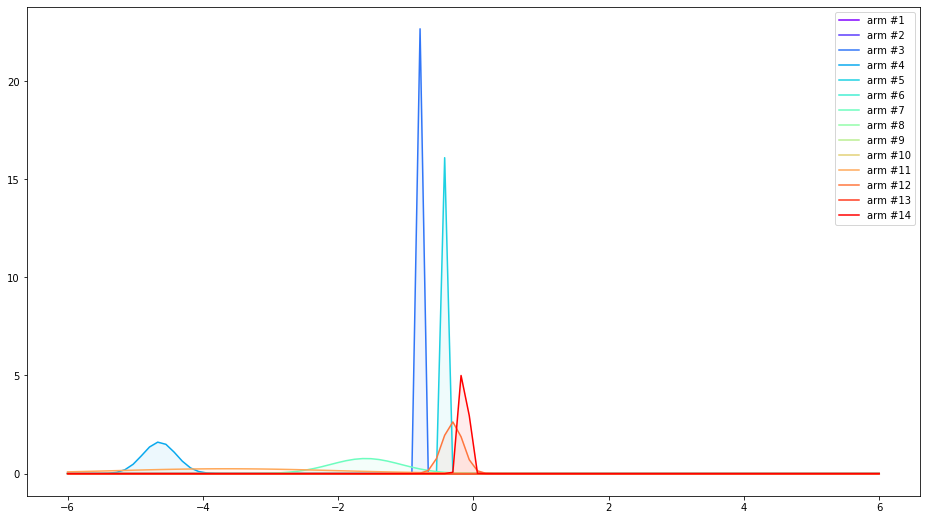

In [ ]:
dts.ts.plot_params()